# SysArmy - Análisis de encuesta 2020.02

## 1. Carga y sanitización de datos

###  1.1. Definimos los metadatos asociados al dataset que vamos a analizar

In [1]:
%load_ext nb_black

csv_url = "https://raw.githubusercontent.com/openqube/openqube-sueldos/release/2021.01/data/csv/argentina/2021.01.csv"

dataset_metadata = {
    "year": 2021,
    "part": 1,
    "skiprows": 0,
    "publish_date": "2021-02-01",
    "minimum_salary": 20587,  # https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina
}

<IPython.core.display.Javascript object>

### 1.2. En base a los metadatos, cargamos el CSV, limpiamos columnas y las transformamos

In [2]:
import pandas as pd
import io
import requests
from time import sleep
import matplotlib.pyplot as plt

raw_dataframe = None
source = requests.get(
    csv_url.format(dataset_metadata["year"], dataset_metadata["part"])
).content
raw_dataframe = pd.read_csv(
    io.StringIO(source.decode("utf-8")),
    skiprows=dataset_metadata["skiprows"],
    thousands=".",
    decimal=",",
)

import re

regex_white_chars = re.compile(r"\s+")
regex_non_alphanum = re.compile(r"\W+_?", re.I)

raw_dataframe.columns = (
    raw_dataframe.columns.str.strip()
    .str.lower()
    .str.replace(regex_white_chars, "_")
    .str.replace(regex_non_alphanum, "")
    .str.translate(
        "ñáéíóú".maketrans({"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"})
    )
)

# Eliminamos los datos que no pertenezcan a Argentina
raw_dataframe = raw_dataframe[raw_dataframe["estoy_trabajando_en"] == "Argentina"]

dataframe = raw_dataframe.copy()

display([column for column in dataframe.columns])

['timestamp',
 'estoy_trabajando_en',
 'donde_estas_trabajando',
 'tipo_de_contrato',
 'salario_mensual_o_retiro_bruto_en_tu_moneda_local',
 'salario_mensual_o_retiro_neto_en_tu_moneda_local',
 'pagos_en_dolares',
 'cual_fue_el_ultimo_valor_de_dolar_que_tomaron',
 'que_tan_conforme_estas_con_tu_sueldo',
 'como_crees_que_esta_tu_sueldo_con_respecto_al_ultimo_semestre',
 'recibis_algun_tipo_de_bono',
 'a_que_esta_atado_el_bono',
 'tuviste_ajustes_por_inflacion_durante_2020',
 'de_que_fue_el_ajuste_total',
 'en_que_mes_fue_el_ultimo_ajuste',
 'trabajo_de',
 'anos_de_experiencia',
 'anos_en_la_empresa_actual',
 'anos_en_el_puesto_actual',
 'gente_a_cargo',
 'plataformas',
 'lenguajes_de_programacion_o_tecnologias',
 'frameworksherramientas_y_librerias',
 'bases_de_datos',
 'qa_testing',
 'ides',
 'cantidad_de_personas_en_tu_organizacion',
 'actividad_principal',
 'la_recomendas_como_un_buen_lugar_para_trabajar',
 'como_calificas_las_politicas_de_diversidad_e_inclusion',
 'beneficios_extra'

<IPython.core.display.Javascript object>

### 1.3. Echamos un vistazo al dataframe previo a sanitizarlo

In [3]:
raw_dataframe.T.head()

,0,1,2,3,4,5,6,7,8,9,...,814,815,816,817,818,819,820,821,822,823
timestamp,12/9/2020 11:56:36,12/9/2020 11:59:46,12/9/2020 12:02:52,12/9/2020 12:03:19,12/9/2020 12:04:07,12/9/2020 12:05:35,12/9/2020 12:06:13,12/9/2020 12:08:56,12/9/2020 12:09:42,12/9/2020 12:10:59,...,12/19/2020 19:16:23,12/19/2020 19:42:55,12/19/2020 20:36:02,12/19/2020 23:04:16,12/19/2020 23:06:40,12/20/2020 0:54:43,12/20/2020 2:05:50,12/20/2020 12:40:31,12/20/2020 17:55:05,12/20/2020 19:49:09
estoy_trabajando_en,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,...,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina
donde_estas_trabajando,Córdoba,Córdoba,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Mendoza,Santa Fe,Ciudad Autónoma de Buenos Aires,...,San Juan,Ciudad Autónoma de Buenos Aires,GBA,Santa Fe,GBA,Santa Fe,Córdoba,Santa Fe,Ciudad Autónoma de Buenos Aires,Salta
tipo_de_contrato,Full-Time,Remoto (empresa de otro país),Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,...,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time
salario_mensual_o_retiro_bruto_en_tu_moneda_local,115000,512000,148000,115620,47300,100000,214600,45000,150000,272000,...,100000,160000,300000,145000,Outlier,80000,50000,165000,90000,44000


<IPython.core.display.Javascript object>

### 1.4. Sanitizamos/normalizamos datos que encontramos mal formados o repetidos

In [4]:
import re


def normalize_dataframe_column(df_in, column_name, regex_assign_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        df_out.loc[mask, column_name] = value

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out


def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, pattern in regex_replace_map.items():
        compiled_regex = re.compile(regex, re.I)
        df_out[column_name] = (
            df_out[column_name].str.strip().str.replace(compiled_regex, pattern)
        )

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out

<IPython.core.display.Javascript object>

#### 1.4.1. Carreras

In [5]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "carrera",
    {
        "(Derecho|Abogac[íi]a|abogad.)": "Derecho",
        "(Contador.*)": "Contador Público",
        "(Arquitect(o|a|ura))": "Arquitectura",
        "(Lic.*)?Psicolog[íi]a": "Licenciatura en Psicología",
        "(Lic.*)?Marketing": "Licenciatura en Marketing",
        ".*Comunicación": "Licenciatura en Comunicación",
        "Letras": "Licenciatura en Letras",
        "Tec.*Infraestructuras{0,2}": "Tecnicatura Superior en Soporte de Infraestructuras",
        "(lic.*qu[ií]mica)": "Licenciatura en Química",
        "^(RRHH|Trabajo)": "Licenciatura en Relaciones del Trabajo",
        "(Lic.*)?Administraci[oó]n( de empresas)?": "Licenciatura en Administración de Empresas",
        "Ed.*f[ií]sica": "Educación Física",
        "Licenciatura en Cienciasdela Computación": "Licenciatura en Ciencias de la Computación",
        "Licenciatura en Ciencias dela Computación": "Licenciatura en Ciencias de la Computación",
        "(ningun(a|o)|-)": "DELETEME",
        "Lic.* Matemáticas?": "Licenciatura en Matemática",
        "(lic.*)econom[íi]a": "Licenciatura en Economía",
        "ingenier[íi]a de sistemas": "Ingeniería en Sistemas",
        "^(.*)\.$": "\\1",
    },
)

df = dataframe["carrera"].value_counts(sort=True)
display(df[:55])

'reduced in 0.015152'

Ingeniería en Sistemas de Información                                        98
Ingeniería en Informática                                                    48
Analista de Sistemas                                                         39
Licenciatura en Sistemas de Información                                      34
Licenciatura en Ciencias de la Computación                                   27
Licenciatura en Informática                                                  22
Ingeniería Electrónica                                                       17
Tecnicatura Superior en Programación                                         17
Tecnicatura en Programación                                                  15
Ingeniería en Computación                                                     8
Licenciatura en Administración de Empresas                                    7
Diseño Gráfico                                                                7
Tecnicatura en Informática              

<IPython.core.display.Javascript object>

#### 1.4.2. Universidades

In [6]:
# En Mendoza se asocia UM a la Universidad de Mendoza, y en Buenos Aires, a la Universidad de Morón
mask = dataframe.eval(
    'universidad in ["UM", "Um"] and donde_estas_trabajando == "Mendoza"'
)
dataframe.universidad.loc[mask] = "Universidad Nacional de Mendoza"
display(dataframe[mask].universidad)

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Series([], Name: universidad, dtype: object)

<IPython.core.display.Javascript object>

In [7]:
dataframe = normalize_dataframe_column(
    dataframe,
    "universidad",
    {
        "(UNSJ|.*Nacional de San Juan)": "UNSJ - Universidad Nacional de San Juan",
        "IRSO": "IRSO - Instituto Raúl Scalabrini Ortíz",
        "(UNPSJB|.*Patagonia San Juan Bosco.*)": "UNPSJB - Universidad Nacional de la Patagonia San Juan Bosco",
        "(UNSL|Universidad Nacional de San Luis)": "UNSL - Universidad Nacional de San Luis",
        "IFTS18": "IFTS18 - Instituto de Formación Técnica Superior N°18",
        "UCASAL": "UCASAL - Universidad Católica de Salta",
        "Universidad de Mendoza": "UM - Universidad de Mendoza",
        "UNTREF": "UNTREF - Universidad Nacional de Tres de Febrero",
        "(UNL[uU]|Universidad Nacional de Luj[aá]n)": "UNLu - Universidad Nacional de Luján",
        "(UAA|.*Atl[aá]ntida.*)": "UAA - Universidad Atlántida Argentina",
        "([fF]?IUPFA)": "IUPFA - Instituto Universitario de la Policía Federal Argentina",
        "([uU]?FASTA)": "FASTA - Fraternidad de Agrupaciones Santo Tomás de Aquino",
        "(UCSE)": "UCSE - Universidad Católica de Santiago del Estero",
        "(ISIV|.*Virasoro.*)": "ISIV - Instituto Superior de Informática Virasoro",
        "(UN[Aa]M)": "UNaM - Universidad Nacional de Misiones",
        "(-|ninguna)$": "DELETEME",
    },
)

df = dataframe["universidad"].value_counts(sort=True)
display(df[:60])

'reduced in 0.010309'

UTN - Universidad Tecnológica Nacional                                        123
UBA - Universidad de Buenos Aires                                              53
UADE - Universidad Argentina De la Empresa                                     19
UAI - Universidad Abierta Interamericana                                       15
UNLP - Universidad Nacional de La Plata                                        15
UNR - Universidad Nacional de Rosario                                          14
UNLaM - Universidad Nacional de La Matanza                                     14
UNC - Universidad Nacional de Córdoba                                          12
UNQ - Universidad Nacional de Quilmes                                           8
UCAECE - Centro de Altos Estudios en Ciencias Exactas                           7
UP - Universidad de Palermo                                                     6
Escuela Da Vinci                                                                6
ORT             

<IPython.core.display.Javascript object>

#### 1.4.3. Experiencia

In [8]:
dataframe["anos_de_experiencia"] = dataframe["anos_de_experiencia"].astype(int)
dataframe["anos_en_la_empresa_actual"] = dataframe["anos_en_la_empresa_actual"].astype(
    int
)
dataframe["anos_en_el_puesto_actual"] = dataframe["anos_en_el_puesto_actual"].astype(
    int
)

<IPython.core.display.Javascript object>

#### 1.4.4. Regiones

In [9]:
dataframe = normalize_dataframe_column(
    dataframe,
    "donde_estas_trabajando",
    {"(GBA|Provincia de Buenos Aires)": "Buenos Aires",},
)

display(dataframe["donde_estas_trabajando"].unique())

'reduced in 0.045455'

array(['Córdoba', 'Ciudad Autónoma de Buenos Aires', 'Mendoza',
       'Santa Fe', 'Buenos Aires', 'Río Negro', 'Entre Ríos', 'San Juan',
       'Jujuy', 'Tucumán', 'Salta', 'Chaco', 'Corrientes', 'Misiones',
       'Neuquén', 'Formosa', 'La Rioja', 'San Luis', 'Chubut',
       'Santiago del Estero', 'Tierra del Fuego'], dtype=object)

<IPython.core.display.Javascript object>

#### 1.4.5. Discapacidad

In [10]:
dataframe = normalize_dataframe_column(
    dataframe,
    "tenes_algun_tipo_de_discapacidad",
    {
        "^(_|-|no( tengo)?|ningun[oa]|nada|0|ni)$": None,
        ".*auditiv[oa].*": "Auditiva",
        ".*visual.*": "Visual",
        "mental": "Mental",
        "motriz": "Motriz",
        "vis?ceral": "Visceral",
    },
)

df = dataframe["tenes_algun_tipo_de_discapacidad"].value_counts(sort=True)
display(df[:6])

'reduced in 0.200000'

Visual                                                                        19
Motriz                                                                         2
Mental                                                                         2
autismo pero nadie lo sabe                                                     1
Visceral                                                                       1
Vote por los K en el 2003 y luego a la Konchuda... Pero ya me cure creo...     1
Name: tenes_algun_tipo_de_discapacidad, dtype: int64

<IPython.core.display.Javascript object>

#### 1.4.5. Roles

In [11]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "trabajo_de",
    {
        "Project Manager.*": "Project Manager",
        "Director, Product Manager, Project Manager": "Manager / Director",
        "Technical Leader.*": "Technical Leader",
        "Team Leader.*": "Technical Leader",
        "Full ?Stack Developer": "Developer",
        "Seguridad Inform[aá]tica": "Infosec",
        "(profesor|instructor|educador|docente|capacitador.*)": "Docente",
        "^(Soporte T[ée]cnico|Technical support|Support)": "Technical Support",
        "Software Engineer": "Developer",
        "(Analista )?programador": "Developer",
        "Analista Funcional": "Functional Analyst",
        "Technical Functional Analyst": "Functional Analyst",
        "administrativo": "Administrativo",
        "^cto.*": "CTO",
        "Asistant": "Assistant",
        "helpdesk": "HelpDesk",
        "(Analista de seguridad|Security.*)": "Infosec",
        "BI Leader": "BI Analyst / Data Analyst",
    },
)

df = dataframe["trabajo_de"].value_counts(sort=True)
display(df[0:50])

'reduced in 0.054054'

Developer                                                                            373
SysAdmin / DevOps / SRE                                                               94
Technical Leader                                                                      42
QA / Tester                                                                           39
HelpDesk                                                                              22
Architect                                                                             19
Infosec                                                                               19
Consultant                                                                            18
Project Manager                                                                       18
Business Analyst                                                                      16
BI Analyst / Data Analyst                                                             16
Data Engineer        

<IPython.core.display.Javascript object>

#### 1.4.6. Salario (corrección de numeración)

In [12]:
# Algunos salarios están cargados, pareciera ser, en miles

<IPython.core.display.Javascript object>

#### 1.4.7. Sueldo dolarizado

In [13]:
mask = dataframe["pagos_en_dolares"].str.contains("", na=False)
column_name = "sueldo_dolarizado"

dataframe.loc[~mask, column_name] = False
dataframe.loc[mask, column_name] = True
dataframe.loc[:, column_name] = dataframe["sueldo_dolarizado"].astype(bool)

<IPython.core.display.Javascript object>

### 1.5. Agregamos columnas calculadas

In [14]:
dataframe["seniority"] = pd.cut(
    dataframe["anos_de_experiencia"].values,
    [-1, 2, 5, 50],
    labels=["Junior", "Semi-Senior", "Senior"],
)
display(dataframe["seniority"])

0           Senior
1           Senior
2           Senior
3      Semi-Senior
4           Junior
          ...     
819         Junior
820         Junior
821         Senior
822    Semi-Senior
823         Junior
Name: seniority, Length: 824, dtype: category
Categories (3, object): ['Junior' < 'Semi-Senior' < 'Senior']

<IPython.core.display.Javascript object>

### 1.6. Eliminamos outliers

In [15]:
salary_debug_columns = [
    "tengo",
    "anos_de_experiencia",
    "estoy_trabajando_en",
    "tipo_de_contrato",
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local",
]


def remove_outlier(df_in, col_name, iqr_factor=1.5):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

<IPython.core.display.Javascript object>

#### 1.6.1. Salarios

In [16]:
dataframe["salario_mensual_o_retiro_bruto_en_tu_moneda_local"] = (
    dataframe["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .str.replace(",", "")
    .str.replace(".", "")
    .str.replace("$", "")
    .str.replace(r"\D", "0")
    .str.extract("(\d+)", expand=False)
    .fillna(0)
    .astype(int)
)

df_inliers, df_outliers = remove_outlier(
    dataframe, "salario_mensual_o_retiro_bruto_en_tu_moneda_local", 3.5
)

# inliers percent over total
display(len(df_inliers) / len(dataframe))

# display outliers
display(df_outliers[salary_debug_columns])

0.9502427184466019

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_o_retiro_bruto_en_tu_moneda_local
1,29,6,Argentina,Remoto (empresa de otro país),512000
50,30,1,Argentina,Full-Time,11341059
56,30,3,Argentina,Full-Time,6798012
72,33,1,Argentina,Full-Time,4780992
74,27,9,Argentina,Full-Time,1550000
119,38,17,Argentina,Full-Time,5592146
182,32,4,Argentina,Full-Time,715000
188,55,30,Argentina,Remoto (empresa de otro país),1000000
257,33,13,Argentina,Remoto (empresa de otro país),600000
265,34,7,Argentina,Remoto (empresa de otro país),1000000


<IPython.core.display.Javascript object>

In [17]:
minimum_salary = dataset_metadata["minimum_salary"]
df_outliers_lower_limit = df_inliers.query(
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local < @minimum_salary/2.0"
)
display(len(df_outliers_lower_limit))
display(df_outliers_lower_limit[salary_debug_columns])
df_inliers_lower_limit = df_inliers.query(
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local >= @minimum_salary/2.0"
)

dataframe = df_inliers_lower_limit

38

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_o_retiro_bruto_en_tu_moneda_local
34,23,0,Argentina,Full-Time,552
39,24,1,Argentina,Participación societaria en una cooperativa,85
71,25,4,Argentina,Full-Time,90
89,37,3,Argentina,Remoto (empresa de otro país),2500
115,39,19,Argentina,Full-Time,1457
117,43,5,Argentina,Full-Time,175
146,20,0,Argentina,Full-Time,40
152,23,4,Argentina,Full-Time,5313
157,24,0,Argentina,Part-Time,10000
198,25,1,Argentina,Part-Time,40


<IPython.core.display.Javascript object>

### 1.7 Helper functions

In [18]:
def invert_non_representative_values(
    dataframe,
    column,
    representative_values,
    value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local",
):
    df.loc[
        df.eval("{} not in @representative_values".format(column)), value_column
    ] *= -1
    return df


def filter_valid_top_values(
    dataframe,
    column,
    top_values,
    value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local",
):
    return dataframe.query(
        '{} in @top_values & {} != "DELETEME"'.format(column, column)
    )


def get_two_dimensional_median_with_outliers_filtered(
    dataframe,
    group_by_columns,
    value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local",
):
    """
  Given a dataframe, groups data by the first given column in group_by_columns, computes median
  and sets to zero all values that have less than 5% of representation on the second column
  """
    dfl = (
        dataframe.groupby(group_by_columns)
        .size()
        .to_frame()
        .groupby(level=0)
        .apply(lambda x: x / float(x.sum()))
        .rename(columns={0: "population"})
        .query("population > 0.05")
        .drop(columns=["population"])
        .reset_index()
    )
    dfr = (
        dataframe.groupby(group_by_columns)
        .median()[value_column]
        .fillna(0)
        .to_frame()
        .reset_index()
    )
    return (
        pd.merge(dfl, dfr, on=group_by_columns, how="inner")
        .groupby(group_by_columns)
        .min()
        .unstack(group_by_columns[1])[value_column]
        .fillna(0)
    )

<IPython.core.display.Javascript object>

## 2. Análisis de resultados

Análisis exploratorio de los datos, los resultados se exportan en un JSON llamado 'charts'

In [19]:
charts = {
    "total_surveyed": len(raw_dataframe),
    "total_analyzed_surveyed": len(dataframe),
}

display(charts)


def to_rechart(df, max=0):
    """
  if max is set, groups the exceeded rows into 'Otros' column, summing values
  """
    if max != 0:
        # df = df.sort_values(by, ascending=False)
        others = df[max:].sum()
        df = df[:max]
        df.loc["Otros"] = others
    return {
        "data": [
            {"name": str(name), **(data if isinstance(data, dict) else {"value": data})}
            for name, data in df.T.to_dict().items()
        ],
    }

{'total_surveyed': 824, 'total_analyzed_surveyed': 745}

<IPython.core.display.Javascript object>

### 2.1. Perfiles

#### 2.1.1. Regiones

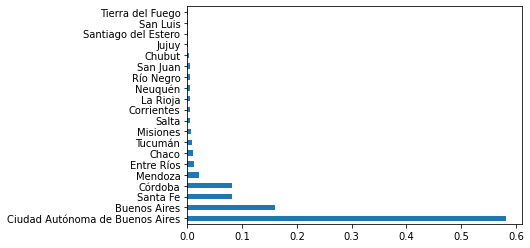

<IPython.core.display.Javascript object>

In [20]:
df = dataframe["donde_estas_trabajando"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["regions_percent"] = to_rechart(df)

#### 2.1.2. Roles (Posición, Open Source, Hobbie)

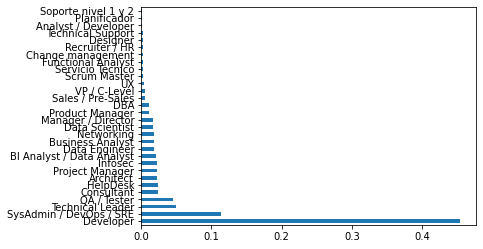

<IPython.core.display.Javascript object>

In [21]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)

df[:30].plot.barh()
charts["roles_percent"] = to_rechart(df, 30)

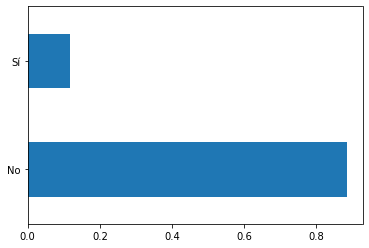

<IPython.core.display.Javascript object>

In [22]:
df = dataframe["contribuis_a_proyectos_open_source"].value_counts(
    normalize=True, sort=True
)

df.plot.barh()
charts["opensource_percent"] = to_rechart(df)

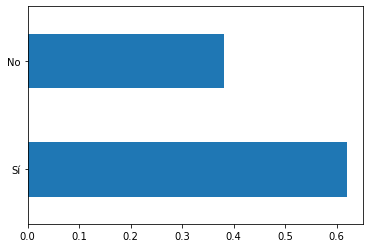

<IPython.core.display.Javascript object>

In [23]:
df = dataframe["programas_como_hobbie"].value_counts(normalize=True, sort=True)

df.plot.barh()
charts["hobbie_percent"] = to_rechart(df)

#### 2.1.3. Experiencia

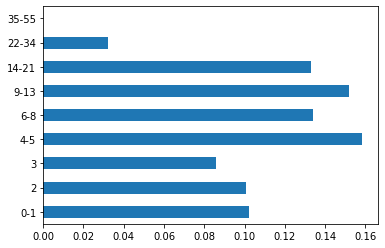

<IPython.core.display.Javascript object>

In [24]:
df = dataframe["anos_de_experiencia"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34", "35-55"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_percent"] = to_rechart(df.sort_index())

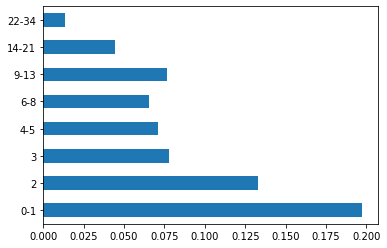

<IPython.core.display.Javascript object>

In [25]:
df = dataframe["anos_en_la_empresa_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_company"] = to_rechart(df.sort_index())

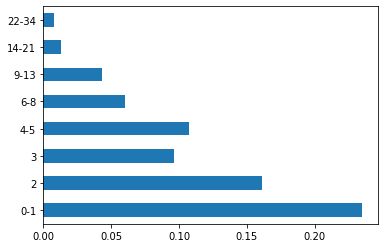

<IPython.core.display.Javascript object>

In [26]:
df = dataframe["anos_en_el_puesto_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_position"] = to_rechart(df.sort_index())

#### 2.1.4. Educación

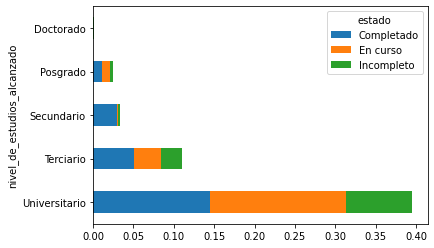

<IPython.core.display.Javascript object>

In [27]:
df = dataframe.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    dataframe
)

df.plot(kind="barh", stacked=True, logx=False)
charts["education_stacked"] = to_rechart(df)

3.725

Index(['Ingeniería en Sistemas de Información', 'Ingeniería en Informática',
       'Licenciatura en Sistemas de Información', 'Analista de Sistemas',
       'Licenciatura en Ciencias de la Computación',
       'Licenciatura en Informática', 'Ingeniería Electrónica',
       'Tecnicatura en Programación', 'Tecnicatura Superior en Programación',
       'Tecnicatura en Informática', 'Ingeniería en Computación',
       'Licenciatura en Administración de Empresas',
       'Analista Programador Universitario', 'Tecnicatura en Sistemas',
       'Analista de Computación', 'Licenciatura en Análisis de Sistemas',
       'Analista Programador', 'Tecnicatura Superior en Análisis de Sistemas',
       'Analista Universitario de Sistemas',
       'Tecnicatura Superior en Sistemas Informáticos', 'Diseño Gráfico',
       'Diseño Multimedial', 'Licenciatura en Psicología',
       'Ingeniería en Software', 'Ingeniería en Telecomunicaciones',
       'Sistemas de Información', 'Ingeniería Industrial'],
   

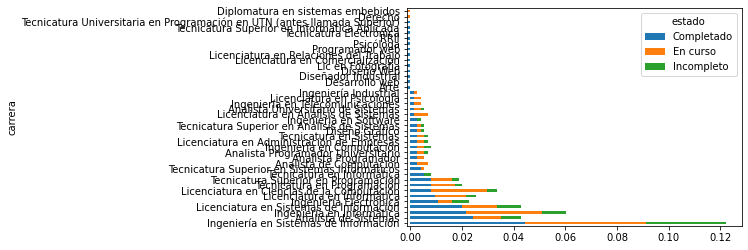

<IPython.core.display.Javascript object>

In [28]:
# Para el grado de completitud por carrera se tendrá en cuenta el tamaño de la muestra, se considerarán insuficientes los datos de aquellas carreras que representen menos del 0.5% del total

df = (
    dataframe["carrera"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("carrera > 0.005")
)

display(len(dataframe["carrera"]) * 0.005)
chosen_careers = df.index
display(chosen_careers)

df = dataframe.query('carrera != "DELETEME"')["carrera"].value_counts(
    normalize=True, sort=True
)
charts["careeres_percent"] = to_rechart(df, 40)

df = dataframe.query('carrera != "DELETEME"').groupby(["carrera", "estado"])[
    "carrera"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df.loc[
    df.eval("carrera not in @chosen_careers"), ["Completado", "En curso", "Incompleto"]
] *= -1

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["careeres_stacked_percent"] = to_rechart(df[:40])

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


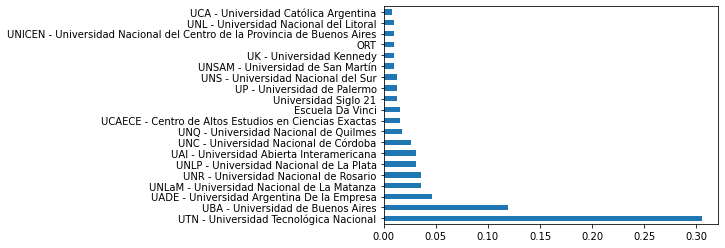

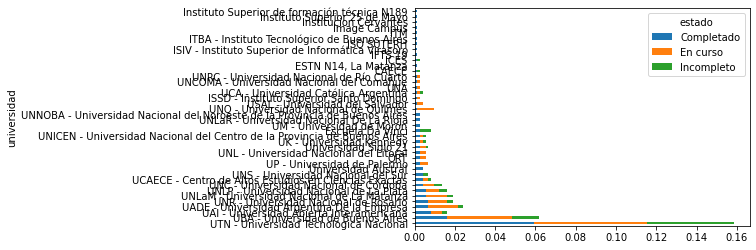

<IPython.core.display.Javascript object>

In [29]:
df = dataframe.query('universidad != "DELETEME"')["universidad"].value_counts(
    normalize=True, sort=True
)

df[:20].plot(kind="barh")
charts["universities_percent"] = to_rechart(df, 40)

df = dataframe.query('universidad != "DELETEME"').groupby(["universidad", "estado"])[
    "universidad"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["universities_stacked_percent"] = to_rechart(df, 40)

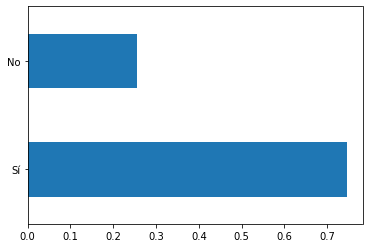

<IPython.core.display.Javascript object>

In [30]:
dc = pd.DataFrame(
    {
        "realizaste_cursos_de_especializacion": dataframe[
            "realizaste_cursos_de_especializacion"
        ].dropna()
    }
)
dc

mask = dc["realizaste_cursos_de_especializacion"].str.contains("Sí")
dc.loc[mask, "hizo_curso"] = "Sí"
dc.loc[~mask, "hizo_curso"] = "No"

df = dc["hizo_curso"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_percent"] = to_rechart(df)

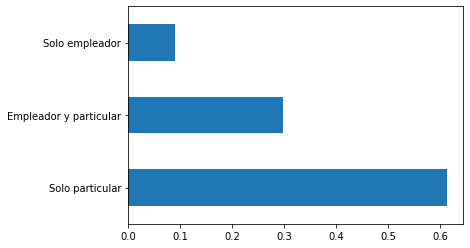

<IPython.core.display.Javascript object>

In [31]:
mask_empleador = dc["realizaste_cursos_de_especializacion"].str.contains("un empleador")
mask_particular = dc["realizaste_cursos_de_especializacion"].str.contains(
    "de forma particular"
)

dc.loc[mask_particular, "quien_paga"] = "Solo particular"
dc.loc[mask_empleador, "quien_paga"] = "Solo empleador"
dc.loc[mask_empleador & mask_particular, "quien_paga"] = "Empleador y particular"

df = dc["quien_paga"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_pays_percent"] = to_rechart(df)

#### 2.1.5. Demografía

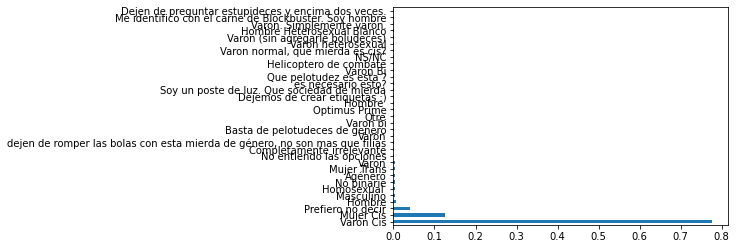

<IPython.core.display.Javascript object>

In [32]:
df = dataframe["me_identifico"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["demographics_gender_percent"] = to_rechart(df)

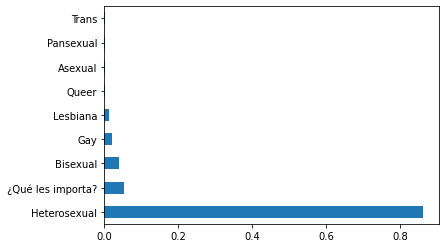

<IPython.core.display.Javascript object>

In [33]:
df = dataframe["identidad_sexual"].value_counts(normalize=True, sort=True)

df[:10].plot(kind="barh")
charts["demographics_sexual_orientation_percent"] = to_rechart(df, 10)

### 2.2. Salarios

#### 2.2.1. Progresión Histórica

https://github.com/openqube/openqube-sueldos/blob/release/2021.01/pipeline/historical-data-analysis.ipynb

#### 2.2.2. Región

In [34]:
# Para el análisis regional se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas regiones que representen menos del 0.5% del total

df = (
    dataframe["donde_estas_trabajando"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("donde_estas_trabajando > 0.005")
)

display(len(dataframe["donde_estas_trabajando"]) * 0.005)
chosen_regions = df.index
display(chosen_regions)

3.725

Index(['Ciudad Autónoma de Buenos Aires', 'Buenos Aires', 'Santa Fe',
       'Córdoba', 'Mendoza', 'Entre Ríos', 'Chaco', 'Tucumán', 'Misiones',
       'Salta', 'Corrientes'],
      dtype='object')

<IPython.core.display.Javascript object>

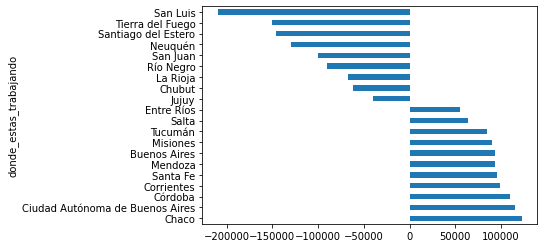

<IPython.core.display.Javascript object>

In [35]:
# Éstas serán convertidas a valores negativos, de manera de poder distinguirlas sin perjudicar a quienes deseen
# observar los resultados más allá del tamaño muestral acotado

df = dataframe.copy()

df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_median"] = to_rechart(df)

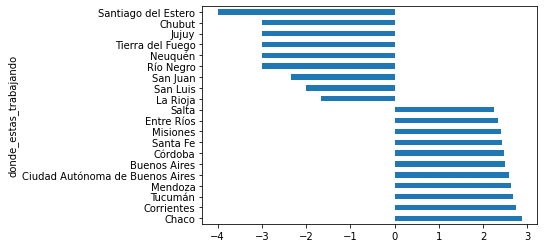

<IPython.core.display.Javascript object>

In [36]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "que_tan_conforme_estas_con_tu_sueldo",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .mean()
    .unstack()["que_tan_conforme_estas_con_tu_sueldo"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_acquiescence"] = to_rechart(df)

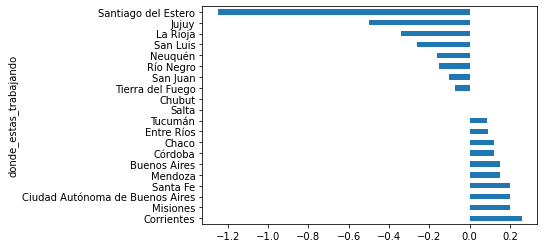

<IPython.core.display.Javascript object>

In [37]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "de_que_fue_el_ajuste_total",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["regions_salary_adjustment"] = to_rechart(df)

##### 2.2.2.1. Región (mínimos por seniority) - no incluídos en el reporte

In [38]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
    ]
    .min()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Chaco,50000.0,30000.0,106000.0
Tucumán,35000.0,120000.0,90000.0
Salta,44000.0,47000.0,80000.0
Córdoba,30000.0,15000.0,69000.0
Mendoza,27000.0,135000.0,57000.0
Corrientes,97000.0,NaN,52000.0
Entre Ríos,55000.0,NaN,50000.0
Misiones,45100.0,132000.0,50000.0
Santa Fe,32000.0,60000.0,48000.0


<IPython.core.display.Javascript object>

##### 2.2.2.2. Región (máximos por seniority) - no incluídos en el reporte

In [39]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
    ]
    .max()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Ciudad Autónoma de Buenos Aires,277945.0,320000.0,465000.0
Córdoba,425000.0,200000.0,450000.0
Mendoza,85000.0,155000.0,450000.0
Entre Ríos,55000.0,NaN,425000.0
Buenos Aires,174500.0,192000.0,410000.0
Santa Fe,374215.0,230000.0,254253.0
Corrientes,97000.0,NaN,165000.0
Chaco,147000.0,180000.0,140000.0
Misiones,45100.0,132000.0,110000.0


<IPython.core.display.Javascript object>

#### 2.2.3. Puesto

##### 2.2.3.1. Seniority

(metodología vieja, queda sólo para reproducir reportes previos)

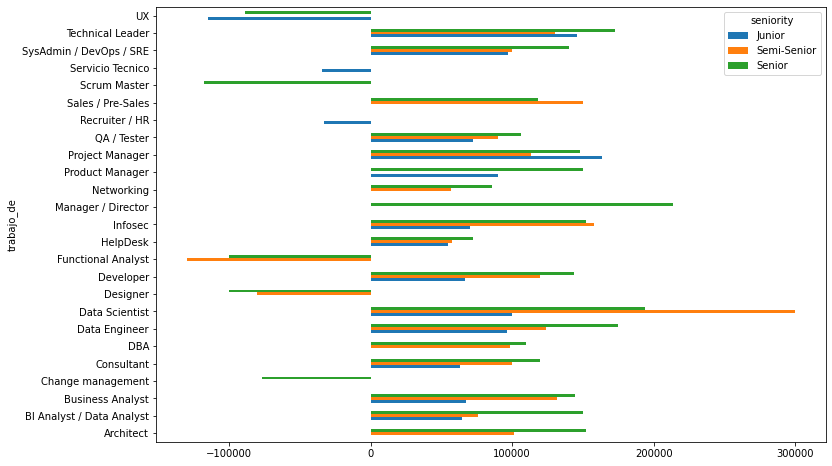

<IPython.core.display.Javascript object>

In [40]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total

df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

chosen_roles = list(df.index)
excluded_roles = {
    "VP / C-Level"
}  # Excluído porque no contaba con todas las seniorities

df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
candidate_roles = list(df[:26].index)
top_roles = [r for r in candidate_roles if r not in excluded_roles]

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

plt.figure(figsize=(12, 8))
df.plot(kind="barh", ax=plt.gca())
charts["roles_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.3.1. Seniority

La metodología previa consideraba a una `position` con "suficientes datos" si la sumatoria de todas sus seniorities (junior, senior, semisr) contenía al menos un 0.5% del total de las respuestas.

La nueva metodología considera cada combinación (`position`, `seniority`) con suficientes datos si hay al menos 6 valores para obtener la mediana.

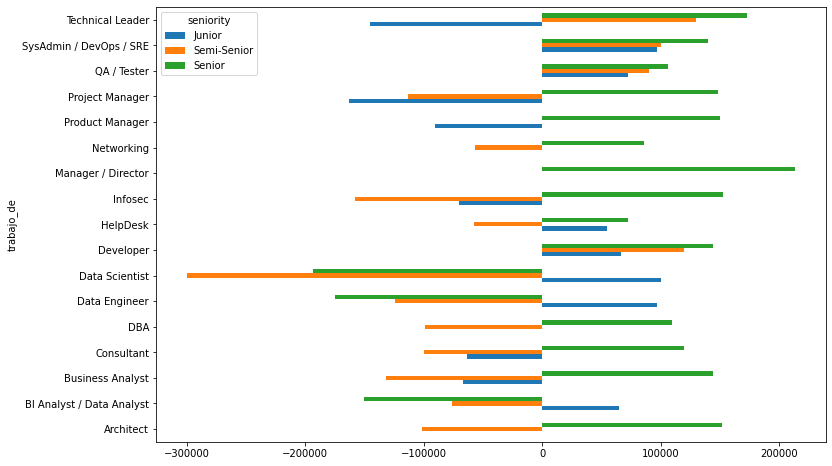

<IPython.core.display.Javascript object>

In [41]:
salary_df = dataframe.copy()[dataframe.seniority.notna()]
salary_df["position_and_seniority"] = salary_df[["trabajo_de", "seniority"]].agg(
    "__".join, axis=1
)

df = (salary_df.position_and_seniority.value_counts(sort=True).to_frame()).query(
    "position_and_seniority > 5"
)
top_positions = df.index
candidate_roles = [position.split("__")[0] for position in top_positions]
excluded_roles = {
    "VP / C-Level"
}  # Excluído porque no contaba con todas las seniorities
top_roles = [r for r in candidate_roles if r not in excluded_roles]

df = (
    salary_df.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

# invert positions and seniorities that have insufficient data.
df *= -1
for pos in top_positions:
    role = pos.split("__")[0]
    if role in excluded_roles:
        continue
    srty = pos.split("__")[1]

    df.loc[role][srty] *= -1

plt.figure(figsize=(12, 8))
df.plot(kind="barh", ax=plt.gca())
charts["roles_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.3.1. Industria

3.725

Index(['Developer', 'SysAdmin / DevOps / SRE', 'Technical Leader',
       'QA / Tester', 'Consultant', 'HelpDesk', 'Architect', 'Project Manager',
       'Infosec', 'BI Analyst / Data Analyst', 'Data Engineer',
       'Business Analyst', 'Networking', 'Data Scientist',
       'Manager / Director', 'Product Manager', 'DBA', 'Sales / Pre-Sales',
       'VP / C-Level'],
      dtype='object')

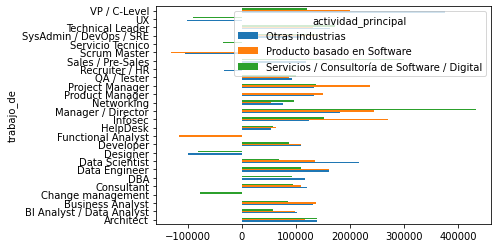

<IPython.core.display.Javascript object>

In [42]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

display(len(dataframe["trabajo_de"]) * 0.005)
chosen_roles = df.index
display(chosen_roles)


df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "actividad_principal"])
    .median()
    .unstack("actividad_principal")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"),
    [
        "Otras industrias",
        "Producto basado en Software",
        "Servicios / Consultoría de Software / Digital",
    ],
] *= -1

df.plot(kind="barh")
charts["roles_actividad_principal_salary_median"] = to_rechart(df[:30])

##### 2.2.3.3. Seniority e Industria

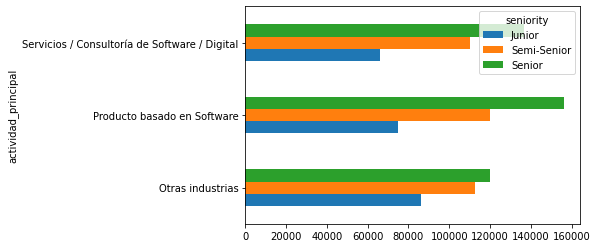

<IPython.core.display.Javascript object>

In [43]:
df = (
    dataframe.groupby(["actividad_principal", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
)  # .sort_values(by=[''],ascending=False)

df.plot.barh()
charts["actividad_principal_seniority_salary_median"] = to_rechart(df)

##### 2.2.3.2. Open source / hobbie

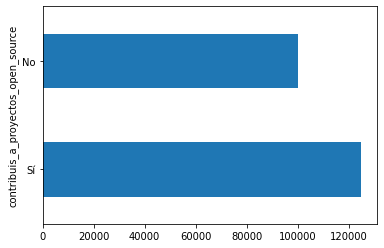

<IPython.core.display.Javascript object>

In [44]:
df = (
    dataframe.groupby(["contribuis_a_proyectos_open_source"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["opensource_salary_median"] = to_rechart(df)

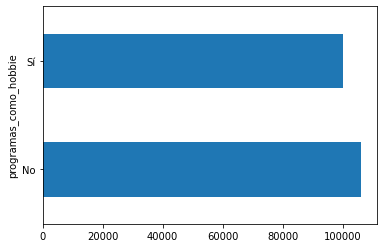

<IPython.core.display.Javascript object>

In [45]:
df = (
    dataframe.groupby(["programas_como_hobbie"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot.barh()
charts["hobbie_salary_median"] = to_rechart(df)

#### 2.2.4. Carrera

In [46]:
df = dataframe.groupby(["carrera", "estado"])["carrera"].count().unstack(
    "estado"
).fillna(0).sort_values(by=["Completado", "En curso"], ascending=False) / len(dataframe)

top_careers = df[:30].index

# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = df[:30]["Completado"].to_frame().query("Completado > 0.005")
display(df)
chosen_careers = df.index

,Completado
carrera,
Ingeniería en Sistemas de Información,0.044295
Analista de Sistemas,0.024161
Ingeniería en Informática,0.021477
Licenciatura en Sistemas de Información,0.020134
Ingeniería Electrónica,0.010738
Licenciatura en Informática,0.009396
Licenciatura en Ciencias de la Computación,0.008054
Tecnicatura en Programación,0.008054
Tecnicatura Superior en Programación,0.008054


<IPython.core.display.Javascript object>

##### 2.2.4.1. Según Seniority

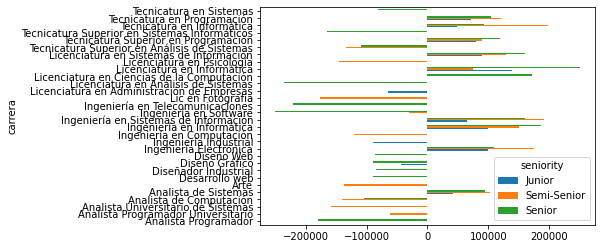

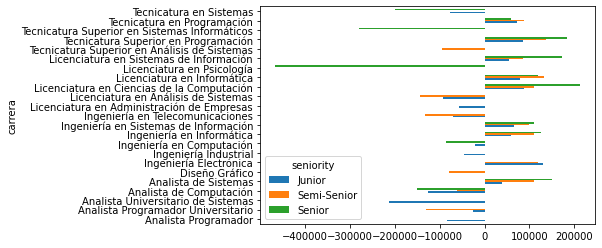

<IPython.core.display.Javascript object>

In [47]:
df = dataframe.query('estado == "Completado"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median"] = to_rechart(df[:30])


df = dataframe.query('estado == "En curso"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median_encurso"] = to_rechart(df[:30])

In [48]:
# Cuántos Ingenieros Industriales hay en el resultado obtenido, ya que sobresale del resto
df = dataframe.query('carrera in ["Ingeniería Industrial"] & estado == "Completado"')[
    ["seniority", "trabajo_de", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
].sort_values(by=["salario_mensual_o_retiro_bruto_en_tu_moneda_local"], ascending=False)

display("Un {:.2f}%".format(len(df) / len(dataframe) * 100))
display(df)

'Un 0.13%'

,seniority,trabajo_de,salario_mensual_o_retiro_bruto_en_tu_moneda_local
288,Junior,Developer,90000


<IPython.core.display.Javascript object>

##### 2.2.4.2. Según Estado de la Carrera

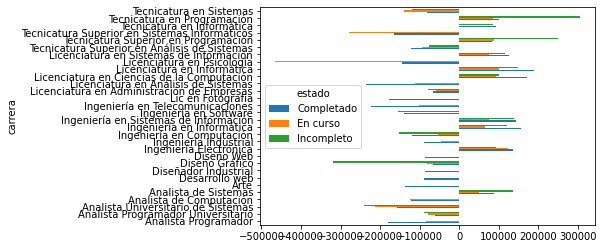

<IPython.core.display.Javascript object>

In [49]:
df = dataframe.copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "estado"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_estado_salary_median"] = to_rechart(df[:30])

##### 2.2.4.3. Según Nivel de Estudios Alcanzado

3.725

Index(['Universitario', 'Terciario', 'Secundario', 'Posgrado'], dtype='object')

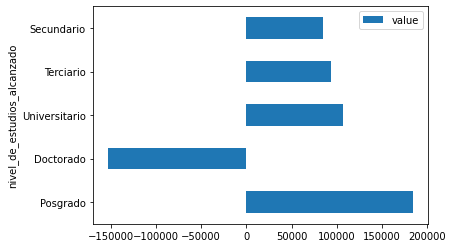

<IPython.core.display.Javascript object>

In [50]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["nivel_de_estudios_alcanzado"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("nivel_de_estudios_alcanzado > 0.005")
)

display(len(dataframe["nivel_de_estudios_alcanzado"]) * 0.005)
chosen_levels = df.index
display(chosen_levels)

df = (
    dataframe.groupby(["nivel_de_estudios_alcanzado"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
    .to_frame("value")
)
df.loc[df.eval("nivel_de_estudios_alcanzado not in @chosen_levels"), "value"] *= -1

df.plot(kind="barh")
charts["nivel_estudios_salary_median"] = to_rechart(df)

##### 2.2.4.4. Según hicieron o no Cursos de Especialización

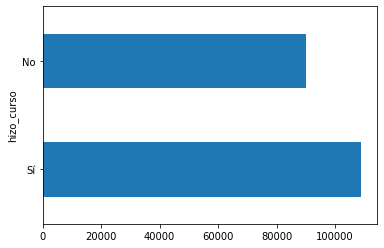

<IPython.core.display.Javascript object>

In [51]:
dc = dataframe[
    [
        "realizaste_cursos_de_especializacion",
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local",
    ]
].dropna()

mask = dc["realizaste_cursos_de_especializacion"].str.contains("Sí")
dc.loc[mask, "hizo_curso"] = "Sí"
dc.loc[~mask, "hizo_curso"] = "No"

df = (
    dc.groupby(["hizo_curso"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")

charts["hizo_curso_salary_median"] = to_rechart(df)

#### 2.2.5. Tecnología

##### 2.2.5.1. Según Plataformas

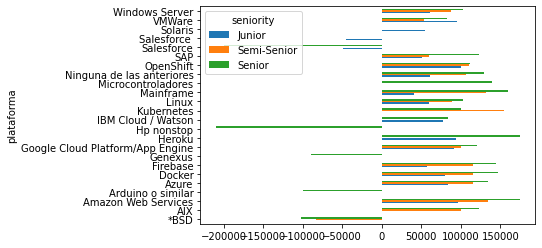

<IPython.core.display.Javascript object>

In [52]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)

top_platforms = df[:30].index
excluded_platforms = {"OpenStack"}  # Excluída para mantener escala
chosen_platforms = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["plataformas"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["plataformas"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"],
        value_name="plataforma",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("plataforma in @top_platforms")
    .query("plataforma not in @excluded_platforms")
    .groupby(["plataforma", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("plataforma not in @chosen_platforms"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

df[:30].plot(kind="barh")
charts["plataformas_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.5.2. Según Lenguajes de Programación

seniority,Junior,Semi-Senior,Senior
lenguajes_de_programacion_o_tecnologias,,,
.NET,64260.0,111500.0,125500.0
ABAP,-0.0,-0.0,-112500.0
ActionScript,-0.0,-0.0,-250000.0
Assembler,-0.0,-0.0,-103000.0
Bash/Shell,87000.0,100000.0,152000.0
C,0.0,116500.0,221700.0
C#,80150.0,86587.5,135000.0
C++,61000.0,0.0,105000.0
COBOL,-90000.0,-0.0,-166500.0


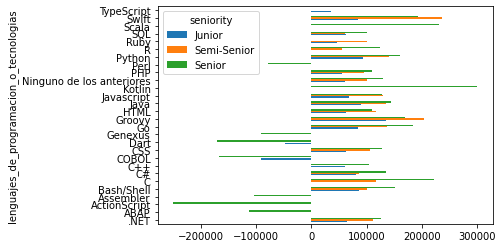

<IPython.core.display.Javascript object>

In [53]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["lenguajes_de_programacion_o_tecnologias"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)
top_languages = df[:30].index

chosen_languages = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["lenguajes_de_programacion_o_tecnologias"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["lenguajes_de_programacion_o_tecnologias"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"],
        value_name="lenguajes_de_programacion_o_tecnologias",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("lenguajes_de_programacion_o_tecnologias in @top_languages")
    .groupby(["lenguajes_de_programacion_o_tecnologias", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("lenguajes_de_programacion_o_tecnologias not in @chosen_languages"),
    ["Junior", "Semi-Senior", "Senior"],
] *= -1

display(df)
df.plot(kind="barh")
charts["lenguajes_de_programacion_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.6. Otras compensaciones

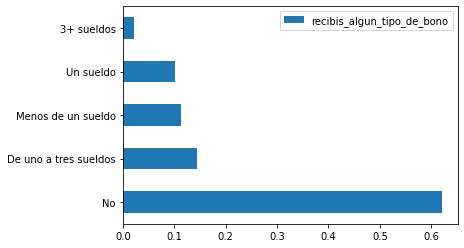

<IPython.core.display.Javascript object>

In [54]:
df = (
    dataframe["recibis_algun_tipo_de_bono"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["bonos_percent"] = to_rechart(df)

#### 2.2.6. Tipo de contrato

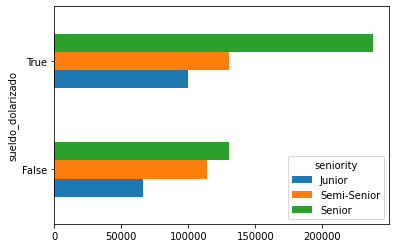

<IPython.core.display.Javascript object>

In [55]:
df = (
    dataframe.groupby(["sueldo_dolarizado", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)
df.plot(kind="barh")
charts["sueldo_dolarizado_salary_median"] = to_rechart(df)

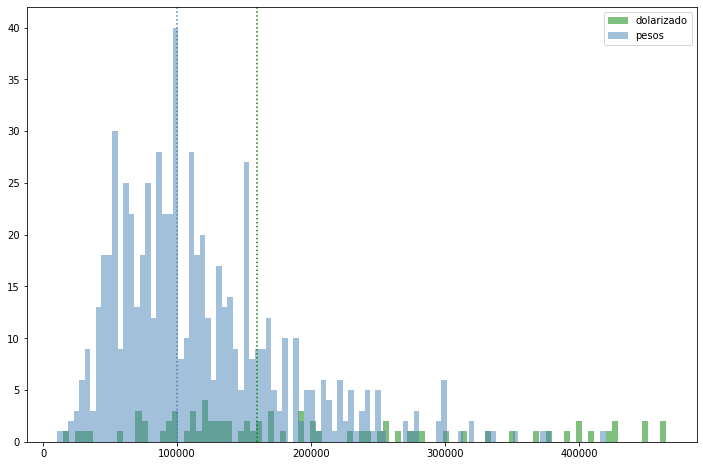

<IPython.core.display.Javascript object>

In [56]:
_, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
_dolar = dataframe[
    dataframe.sueldo_dolarizado
].salario_mensual_o_retiro_bruto_en_tu_moneda_local
_no_dolar = dataframe[
    ~dataframe.sueldo_dolarizado
].salario_mensual_o_retiro_bruto_en_tu_moneda_local
ax.hist(_dolar, bins=100, label="dolarizado", alpha=0.5, color="green")
ax.hist(_no_dolar, bins=100, label="pesos", alpha=0.5, color="steelblue")
ax.axvline(_dolar.median(), color="green", linestyle="dotted")
ax.axvline(_no_dolar.median(), color="steelblue", linestyle="dotted")
ax.legend()

### 2.3. Género

#### 2.3.1. Progresión Histórica

#### 2.3.2. Preparación

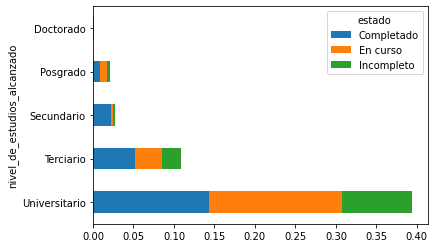

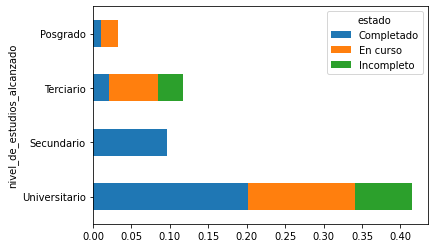

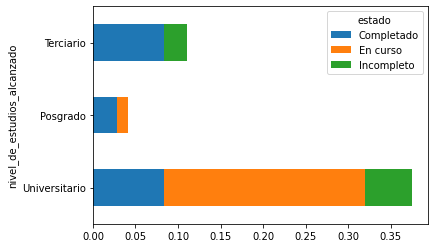

<IPython.core.display.Javascript object>

In [57]:
df = dataframe.query('me_identifico == "Varón Cis"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_hombre_stacked"] = to_rechart(df)

df = dataframe.query('me_identifico == "Mujer Cis"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_mujer_stacked"] = to_rechart(df)

# df = dataframe.query('me_identifico == "Otros"')
df = dataframe[
    (dataframe["me_identifico"] != "Mujer Cis")
    & (dataframe["me_identifico"] != "Varón Cis")
]
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
).sort_values(
    by=["En curso"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)

charts["education_otros_stacked"] = to_rechart(df)

#### 2.3.3. Salarios

In [58]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

top_salary_roles = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de"])
    .median()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)
top_salary_roles_mujer = (
    dataframe.query(
        'trabajo_de in @top_roles & me_identifico == "Mujer Cis" | me_identifico == "Mujer Trans"'
    )
    .groupby(["trabajo_de"])
    .median()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)

# Roles mejores pagos en los que no se encuentran mujeres
display([rol for rol in top_salary_roles if rol not in top_salary_roles_mujer])

['VP / C-Level',
 'Architect',
 'Data Scientist',
 'Scrum Master',
 'DBA',
 'Consultant',
 'Change management',
 'Networking',
 'Servicio Tecnico']

<IPython.core.display.Javascript object>

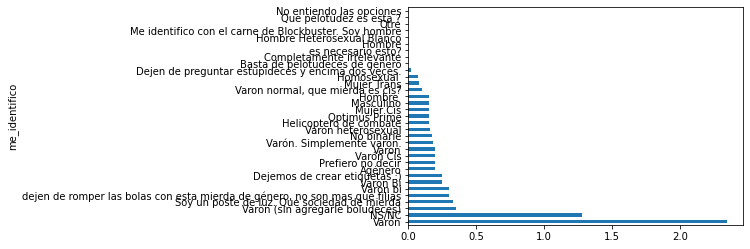

<IPython.core.display.Javascript object>

In [59]:
df = (
    dataframe.groupby(["me_identifico"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["gender_salary_adjustment"] = to_rechart(df)

#### 2.3.4. Experiencia

me_identifico,Agénero,Basta de pelotudeces de genero,Completamente irrelevante,Dejemos de crear etiquetas :),Dejen de preguntar estupideces y encima dos veces.,Helicoptero de combate,Hombre,Hombre,Hombre Heterosexual Blanco,Homosexual,...,Varon Bi,Varon bi,Varon heterosexual,"Varon normal, que mierda es cis?",Varón,Varón (sin agregarle boludeces),Varón Cis,Varón. Simplemente varón.,"dejen de romper las bolas con esta mierda de género, no son mas que filias",es necesario esto?
actividad_principal,,,,,,,,,,,,,,,,,,,,,
Otras industrias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005208,NaN,0.015625,...,NaN,0.005208,0.005208,NaN,NaN,NaN,0.807292,0.005208,NaN,0.005208
Producto basado en Software,0.003610,NaN,NaN,NaN,NaN,NaN,0.010830,NaN,NaN,NaN,...,0.00361,NaN,NaN,NaN,NaN,NaN,0.783394,NaN,NaN,NaN
Servicios / Consultoría de Software / Digital,0.003623,0.003623,0.003623,0.003623,0.003623,0.003623,0.007246,NaN,0.003623,NaN,...,NaN,NaN,NaN,0.003623,0.003623,0.003623,0.750000,NaN,0.003623,NaN


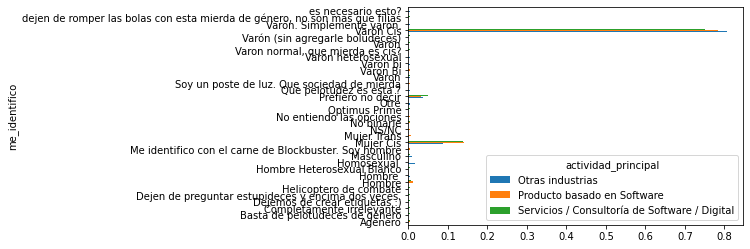

<IPython.core.display.Javascript object>

In [60]:
df = dataframe
df = (
    df.groupby(["actividad_principal", "me_identifico"])
    .agg({"me_identifico": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_identifico")
)
df.columns = df.columns.droplevel(0)
display(df)
df.T.plot(kind="barh")
charts["actividad_principal_gender_percent"] = to_rechart(df)

me_identifico,Agénero,Basta de pelotudeces de genero,Completamente irrelevante,Dejemos de crear etiquetas :),Dejen de preguntar estupideces y encima dos veces.,Helicoptero de combate,Hombre,Hombre,Hombre Heterosexual Blanco,Homosexual,...,Varon Bi,Varon bi,Varon heterosexual,"Varon normal, que mierda es cis?",Varón,Varón (sin agregarle boludeces),Varón Cis,Varón. Simplemente varón.,"dejen de romper las bolas con esta mierda de género, no son mas que filias",es necesario esto?
anos_de_experiencia_fibo,,,,,,,,,,,,,,,,,,,,,
0-1,0.000000,0.00000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.000,...,0.000000,0.00000,0.000000,0.000000,0.013158,0.000000,0.750000,0.00000,0.0,0.000000
2,0.013333,0.00000,0.013333,0.00,0.000000,0.0,0.026667,0.00,0.000000,0.000,...,0.000000,0.00000,0.000000,0.013333,0.000000,0.013333,0.733333,0.00000,0.0,0.000000
3,0.000000,0.00000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.812500,0.00000,0.0,0.015625
4-5,0.000000,0.00000,0.000000,0.00,0.008475,0.0,0.008475,0.00,0.000000,0.000,...,0.008475,0.00000,0.000000,0.000000,0.000000,0.000000,0.830508,0.00000,0.0,0.000000
6-8,0.010000,0.00000,0.000000,0.01,0.000000,0.0,0.010000,0.01,0.000000,0.000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.790000,0.00000,0.0,0.000000
9-13,0.000000,0.00885,0.000000,0.00,0.000000,0.0,0.008850,0.00,0.000000,0.000,...,0.000000,0.00885,0.000000,0.000000,0.000000,0.000000,0.796460,0.00885,0.0,0.000000
14-21,0.000000,0.00000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.010101,0.000,...,0.000000,0.00000,0.010101,0.000000,0.000000,0.000000,0.878788,0.00000,0.0,0.000000
22-55,0.000000,0.00000,0.000000,0.00,0.000000,0.0,0.000000,0.00,0.000000,0.125,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.625000,0.00000,0.0,0.000000


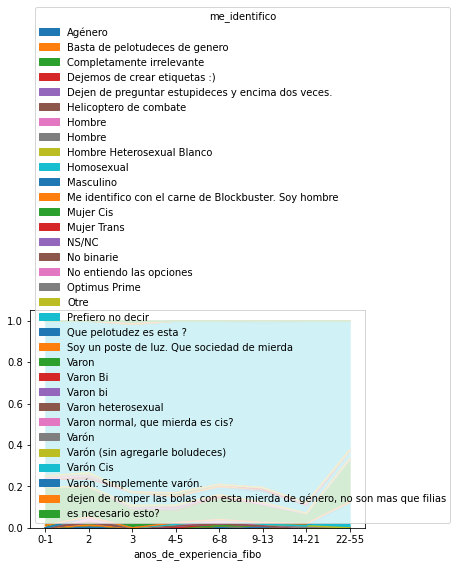

<IPython.core.display.Javascript object>

In [61]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"me_identifico": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="area")
charts["experience_gender_percent"] = to_rechart(df)

me_identifico,Agénero,Basta de pelotudeces de genero,Completamente irrelevante,Dejemos de crear etiquetas :),Dejen de preguntar estupideces y encima dos veces.,Helicoptero de combate,Hombre,Hombre,Hombre Heterosexual Blanco,Homosexual,...,Varon Bi,Varon bi,Varon heterosexual,"Varon normal, que mierda es cis?",Varón,Varón (sin agregarle boludeces),Varón Cis,Varón. Simplemente varón.,"dejen de romper las bolas con esta mierda de género, no son mas que filias",es necesario esto?
anos_de_experiencia_fibo,,,,,,,,,,,,,,,,,,,,,
0-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,51870.0,0.0,70000.0,0.0,0.0,0.0
2,100000.0,0.0,160000.0,0.0,0.0,0.0,146414.5,0.0,0.0,0.0,...,0.0,0.0,0.0,84000.0,0.0,55000.0,86000.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,110000.0,0.0,0.0,150000.0
4-5,0.0,0.0,0.0,0.0,43313.0,0.0,119000.0,0.0,0.0,0.0,...,155000.0,0.0,0.0,0.0,0.0,0.0,122500.0,0.0,0.0,0.0
6-8,211500.0,0.0,0.0,93000.0,0.0,0.0,210000.0,79000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,141394.0,0.0,0.0,0.0
9-13,0.0,125000.0,0.0,0.0,0.0,0.0,100000.0,0.0,0.0,0.0,...,0.0,93350.0,0.0,0.0,0.0,0.0,147000.0,85000.0,0.0,0.0
14-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,450000.0,0.0,...,0.0,0.0,170000.0,0.0,0.0,0.0,137356.0,0.0,0.0,0.0
22-55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,150000.0,0.0,0.0,0.0


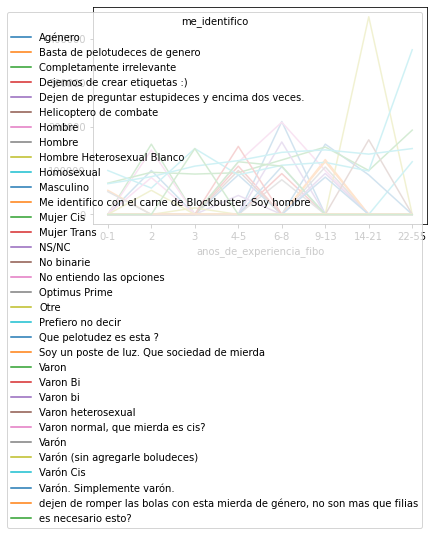

<IPython.core.display.Javascript object>

In [62]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"salario_mensual_o_retiro_bruto_en_tu_moneda_local": "median"})
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_salary_median"] = to_rechart(df)

me_identifico,Agénero,Basta de pelotudeces de genero,Completamente irrelevante,Dejemos de crear etiquetas :),Dejen de preguntar estupideces y encima dos veces.,Helicoptero de combate,Hombre,Hombre,Hombre Heterosexual Blanco,Homosexual,...,Varon Bi,Varon bi,Varon heterosexual,"Varon normal, que mierda es cis?",Varón,Varón (sin agregarle boludeces),Varón Cis,Varón. Simplemente varón.,"dejen de romper las bolas con esta mierda de género, no son mas que filias",es necesario esto?
anos_de_experiencia_fibo,,,,,,,,,,,,,,,,,,,,,
0-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,2.561404,0.0,0.0,0.0
2,3.0,0.0,2.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,1.0,2.654545,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.634615,0.0,0.0,3.0
4-5,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2.469388,0.0,0.0,0.0
6-8,2.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.772152,0.0,0.0,0.0
9-13,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.544444,3.0,0.0,0.0
14-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,2.436782,0.0,0.0,0.0
22-55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.533333,0.0,0.0,0.0


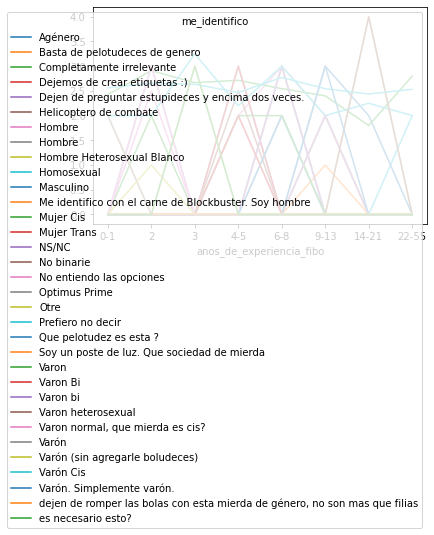

<IPython.core.display.Javascript object>

In [63]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_identifico"])
    .agg({"que_tan_conforme_estas_con_tu_sueldo": "mean"})
    .unstack("me_identifico")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_conformidad_mean"] = to_rechart(df)

#### 2.3.5. Discapacidad

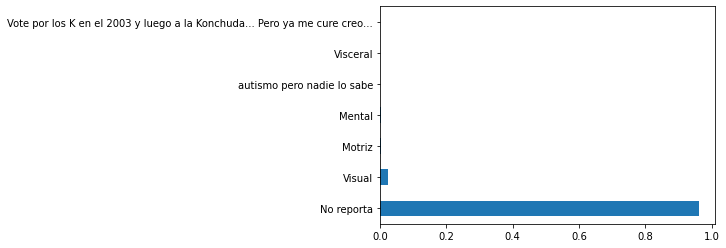

<IPython.core.display.Javascript object>

In [64]:
df = dataframe["tenes_algun_tipo_de_discapacidad"].fillna("No reporta").value_counts(
    normalize=False, sort=True
) / len(dataframe)

# df = dataframe['tenes_algun_tipo_de_discapacidad'].value_counts(normalize=True, sort=True)#.to_frame()

df[:7].plot(kind="barh")
charts["discapacidad_percent"] = to_rechart(df, 7)

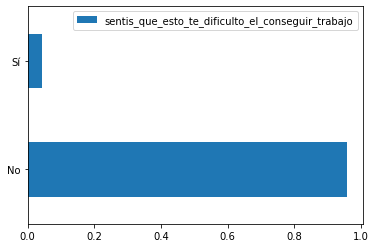

<IPython.core.display.Javascript object>

In [65]:
# Quienes respondieron Sí o No, son quienes contestaron sobre discapacidad.  El resto es None
df = (
    dataframe["sentis_que_esto_te_dificulto_el_conseguir_trabajo"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["discapacidad_dificultad_percent"] = to_rechart(df)

### 2.4. Tecnología

#### 2.4.1. Plataformas más populares

'reduced in 0.000000'

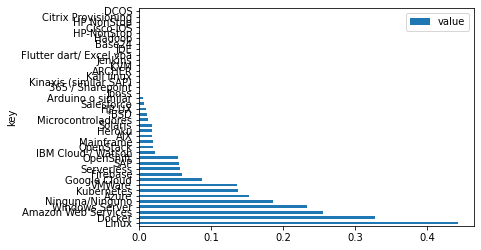

<IPython.core.display.Javascript object>

In [66]:
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "Google Cloud Platform/App Engine": "Google Cloud",
        "Sap": "SAP",
        "crm": "CRM",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:40].plot.barh()
charts["plataformas"] = to_rechart(df[:40])

#### 2.4.2. Lenguajes de Programación más populares

'reduced in 0.014493'

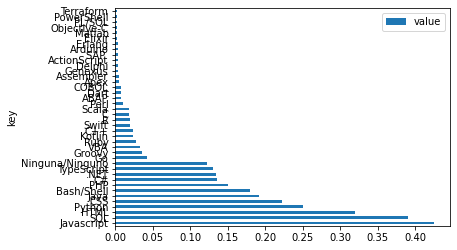

<IPython.core.display.Javascript object>

In [67]:
df = (
    dataframe["lenguajes_de_programacion_o_tecnologias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "powershell": "PowerShell",
        "cobol": "COBOL",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:40].plot.barh()
charts["lenguajes_de_programacion"] = to_rechart(df[:40])

#### 2.4.3. Frameworks, Herramientas y Librerías más populares

'reduced in 0.037037'

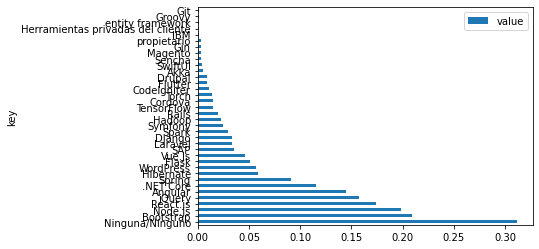

<IPython.core.display.Javascript object>

In [68]:
df = (
    dataframe["frameworksherramientas_y_librerias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(node).*$": "Node.js",
        ".*Angular.*$": "Angular",
        ".*React.*$": "React.js",
        ".*Vue.*$": "Vue.js",
        ".*jquery.*$": "jQuery",
        ".*laravel.*$": "Laravel",
        ".*codeigniter.*$": "CodeIgniter",
        ".*struts.*$": "Struts",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:36].plot.barh()
charts["frameworksherramientas_y_librerias"] = to_rechart(df[:36])

#### 2.4.4. Bases de Datos más populares

'reduced in 0.060000'

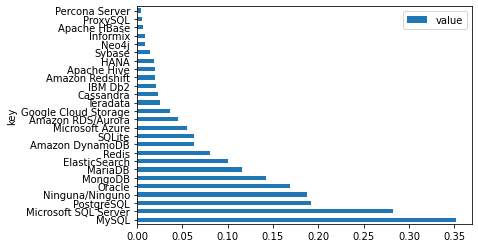

<IPython.core.display.Javascript object>

In [69]:
df = (
    dataframe["bases_de_datos"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(sybase).*$": "Sybase",
        "Microsoft Azure \(Tables": "Microsoft Azure",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
        "^(SQL|CosmosDB|etc\)|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["bases_de_datos"] = to_rechart(df[:26])

#### 2.4.5. Herramientas de QA / Testing más populares

'reduced in 0.089286'

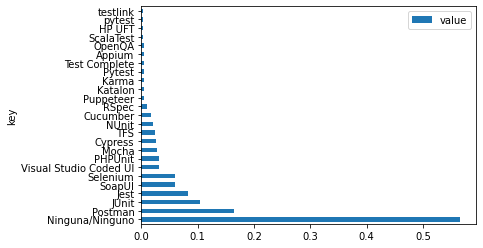

<IPython.core.display.Javascript object>

In [70]:
df = (
    dataframe["qa_testing"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(ningun[oa]|no|nada|otros?|0|\.).*$": "DELETEME",
        ".*(junit).*$": "JUnit",
        ".*(jest).*$": "Jest",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:25].plot.barh()
charts["qa_testing"] = to_rechart(df[:25])

#### 2.4.6. IDEs más populares

'reduced in 0.085106'

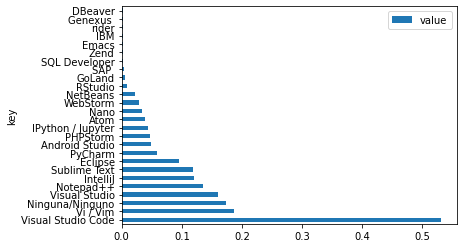

<IPython.core.display.Javascript object>

In [71]:
df = (
    dataframe["ides"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "^.*(Visual Studio|VS).*$": "Visual Studio",
        "^.*(Visual Studio Code|VS ?Code|Code).*$": "Visual Studio Code",
        ".*(Sublime)( Text)?.*$": "Sublime Text",
        ".*(webstorm).*$": "WebStorm",
        "^(vi|vim)$": "Vi / Vim",
        "^(jdeveloper)$": "JDeveloper",
        "^(goland)$": "GoLand",
        "^(neovim)$": "NeoVim",
        "IBM integración toolkit": "IBM Integration Bus",
        "^(rubymine)$": "RubyMine",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(no( uso.*| util.*)?|none|ningun[ao]|0|No s[eé]|nada|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["ides"] = to_rechart(df[:26])

### 2.5. Trabajo

#### 2.5.1. Tipos de contrato

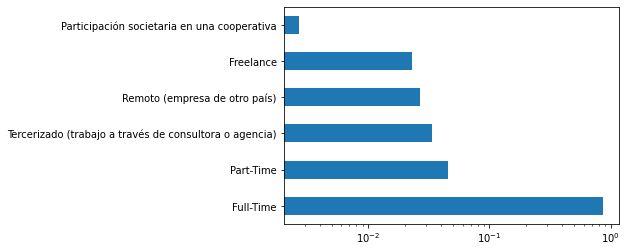

<IPython.core.display.Javascript object>

In [72]:
df = dataframe["tipo_de_contrato"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["tipo_de_contrato_percent"] = to_rechart(df)

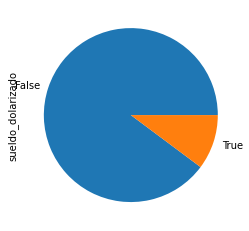

<IPython.core.display.Javascript object>

In [73]:
df = dataframe["sueldo_dolarizado"].value_counts(normalize=True, sort=True)
df.plot.pie()
charts["sueldo_dolarizado_percent"] = to_rechart(df)

#### 2.5.2. Compensación

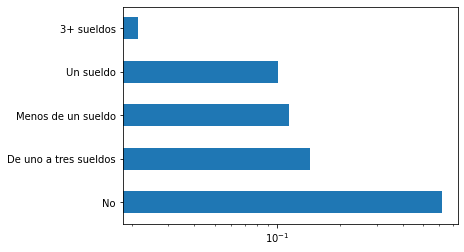

<IPython.core.display.Javascript object>

In [74]:
df = dataframe["recibis_algun_tipo_de_bono"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["recibis_algun_tipo_de_bono"] = to_rechart(df)

'reduced in 0.173913'

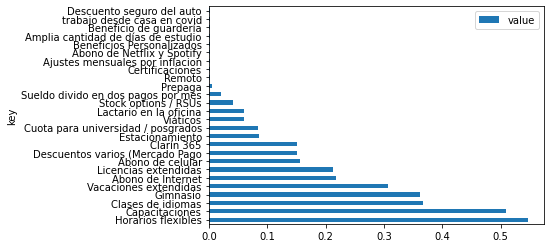

<IPython.core.display.Javascript object>

In [75]:
df = (
    dataframe["beneficios_extra"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*Vacaciones flexibles.*$": "Vacaciones extendidas",
        ".*Licencias?.*$": "Licencias extendidas",
        "horarios? flexibles?$": "Horarios flexibles",
        "(.*capacitaci[oó]n(es)?.*|.*cursos?.*)$": "Capacitaciones",
        "bebidas?$": "Bebidas",
        "(golosinas?|snac?ks?)$": "Snacks",
        "(Descuentos varios \(Clarín 365)$": "Descuentos varios",
        "(etc\)|Club La Nación)$": "DELETEME",
        "(no|.*Nada.*|Ning[uú]n[ao]?( de las anteriores)?)$": "DELETEME",
        "(.*prepaga.*|OSDE|.*obra social.*)$": "Prepaga",
        "(frut[ao]s?)$": "Frutas",
        "(facturas?)": "Facturas",
        "(.*home off?ice.*|.*WFH.*|.*home work.*)$": "WFH",
        "(.*d[oó]lares.*|Sueldo dolarizado)$": "Sueldo dolarizado",
        "(.*gimnasio.*|.*gym.*)$": "Gimnasio",
        "(.*cochera.*|.*estacionamiento.*)$": "Estacionamiento",
        "(.*combustibles?.*|.*vi[aá]ticos?.*|.*cabify.*|.*transporte.*|.*remis.*)$": "Viáticos",
        "(.*sueldos? ex.*)$": "Sueldos extra",
        "(.*eventos?.*|entradas?)$": "Eventos",
        "(.*pileta)$": "Pileta",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["beneficios_extra"] = to_rechart(df[:26])

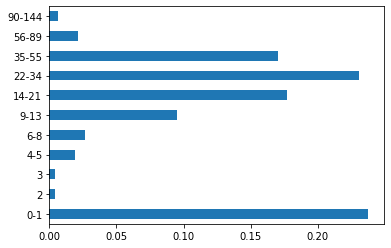

<IPython.core.display.Javascript object>

In [76]:
df = dataframe["de_que_fue_el_ajuste_total"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144],
        labels=[
            "0-1",
            "2",
            "3",
            "4-5",
            "6-8",
            "9-13",
            "14-21",
            "22-34",
            "35-55",
            "56-89",
            "90-144",
        ],
        include_lowest=True,
    )
).count() / len(df)

df.plot.barh()
charts["de_que_fue_el_ajuste"] = to_rechart(df.sort_index())

#### 2.5.3. Características de la Empresa

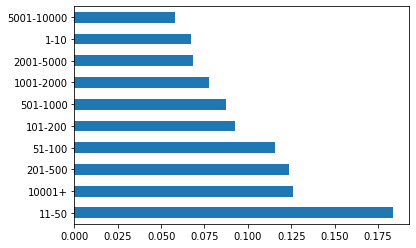

<IPython.core.display.Javascript object>

In [77]:
df = dataframe["cantidad_de_personas_en_tu_organizacion"].value_counts(
    normalize=True, sort=True
)

df.plot(kind="barh", logx=False)
charts["cantidad_de_personas"] = to_rechart(df)

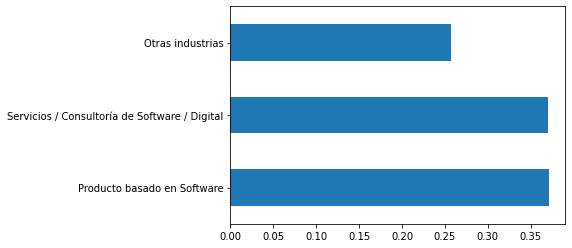

<IPython.core.display.Javascript object>

In [78]:
df = dataframe["actividad_principal"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["actividad_principal"] = to_rechart(df)

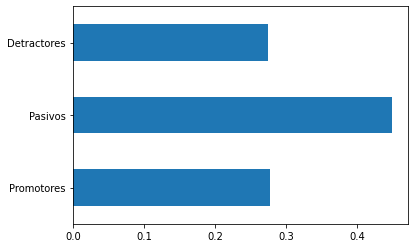

<IPython.core.display.Javascript object>

In [79]:
df = dataframe["la_recomendas_como_un_buen_lugar_para_trabajar"].copy()
# https://es.wikipedia.org/wiki/Net_Promoter_Score
df = df.groupby(
    pd.cut(df.values, [0, 6, 8, 10], labels=["Detractores", "Pasivos", "Promotores"])
).count() / len(df)
df = df.iloc[::-1]  # reverse order

df.plot.barh()
charts["la_recomendas_como_un_buen_lugar_para_trabajar"] = to_rechart(df)

## 3. Publicación

In [81]:
import json

# formateamos valores flotantes para ahorrar caracteres (#macritips)
display(
    json.dumps(
        json.loads(
            json.dumps(charts, allow_nan=True),
            parse_float=lambda x: round(float(x), 5),
        )
    )
)

'{"total_surveyed": 824, "total_analyzed_surveyed": 745, "regions_percent": {"data": [{"name": "Ciudad Aut\\u00f3noma de Buenos Aires", "value": 0.58255}, {"name": "Buenos Aires", "value": 0.15973}, {"name": "Santa Fe", "value": 0.08188}, {"name": "C\\u00f3rdoba", "value": 0.08188}, {"name": "Mendoza", "value": 0.02148}, {"name": "Entre R\\u00edos", "value": 0.01208}, {"name": "Chaco", "value": 0.01074}, {"name": "Tucum\\u00e1n", "value": 0.00805}, {"name": "Misiones", "value": 0.00671}, {"name": "Salta", "value": 0.00537}, {"name": "Corrientes", "value": 0.00537}, {"name": "La Rioja", "value": 0.00403}, {"name": "Neuqu\\u00e9n", "value": 0.00403}, {"name": "R\\u00edo Negro", "value": 0.00403}, {"name": "San Juan", "value": 0.00403}, {"name": "Chubut", "value": 0.00268}, {"name": "Jujuy", "value": 0.00134}, {"name": "Santiago del Estero", "value": 0.00134}, {"name": "San Luis", "value": 0.00134}, {"name": "Tierra del Fuego", "value": 0.00134}]}, "roles_percent": {"data": [{"name": "Dev

<IPython.core.display.Javascript object>